In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from scipy.signal import find_peaks
output_notebook()

from uncertainties import ufloat

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=False, grid=False)

import matplotlib as mpl

# Edit the font, font size, and axes width
# mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/trevormjs/Documents/Science/APL/Lab')

from Helper.plotting import my_graph
import Helper.numbers as nu

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Part A: Room Light Spectrum

#### data

In [898]:
bkg = pd.read_csv('../Lab3/Data/A1. Background Noise.txt',
                  delimiter='\t', header=None)
bkg.integration_time = 5e-5

green = pd.read_csv('../Lab3/Data/A2a Green Light Spectrum.txt',
                    delimiter='\t', header=None)

lablight = pd.read_csv('../Lab3/Data/A3a2 Lab Light.txt',
                       delimiter='\t', header=None, skiprows = 14)
lablight.integration_time = 2.000000e-1

for df in [bkg, green, lablight]:
    df.columns = ['Wavelength', 'Intensity']
    if 'integration_time' in dir(df):
        df.Intensity /= df.integration_time

In [901]:
lablight.describe()

,Wavelength,Intensity
count,3648.000000,3648.000000
mean,712.111339,6024.901727
std,202.610737,22338.094947
min,345.532000,-1900.350000
25%,538.606500,-59.712500
50%,720.520500,413.850000
75%,889.827500,2259.600000
max,1045.083000,267028.650000


#### Calibration

(520.0, 550.0)

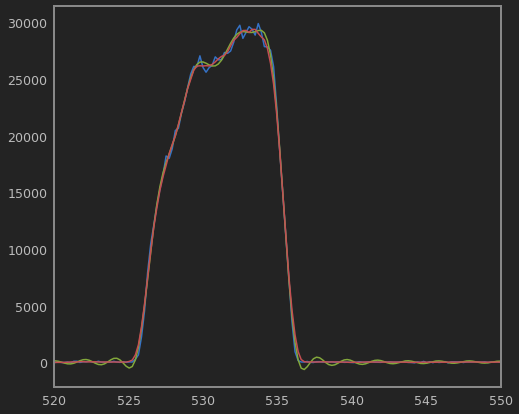

In [322]:
plt.plot(green.Wavelength, green.Intensity)
plt.plot(green.Wavelength, nu.fft_filter(green.Intensity, .1))
plt.plot(green.Wavelength, nu.moving_avg_filter(green.Intensity, 5))
plt.xlim([520, 550])

In [233]:
green.insert(green.shape[1], 'smooth', moving_avg_filter(green.Intensity, 5))

ValueError: cannot insert smooth, already exists

In [237]:
nm = nanometer_correction = green.loc[green.smooth==green.smooth.max(), 'Wavelength'].values[0] - 532
nanometer_correction

1.5059999999999718

#### Room lights

In [907]:
fig = figure()
fig.line(bkg.Wavelength, bkg.Intensity)
fig.line(bkg.Wavelength, fft_filter(bkg.Intensity, .1), color = 'red')
fig.line(bkg.Wavelength, moving_avg_filter(bkg.Intensity, 10), color = 'green')
show(fig)
bkg['smooth'] = moving_avg_filter(bkg.Intensity, 10)

In [902]:
fig = figure()
fig.line(lablight.Wavelength, lablight.Intensity)
fig.line(lablight.Wavelength, fft_filter(lablight.Intensity, .1), color = 'red')
fig.line(lablight.Wavelength, moving_avg_filter(lablight.Intensity, 10), color = 'green')
show(fig)
lablight['smooth'] = moving_avg_filter(lablight.Intensity, 10)

In [903]:
peak_wavelenghts, peak_heights = nu.peak(
    lablight.smooth, 6, indeces=lablight.Wavelength)
peaks = lablight.smooth[peak_inds]
peak_df = pd.DataFrame({
    'Intensity': peaks,
    'Wavelength': lablight.Wavelength[peak_inds]
})
peak_df

,Intensity,Wavelength
935,184731.050000,543.390
1271,206232.863636,611.697
1140,36053.172727,585.251
669,29802.218182,488.232
426,10386.540909,437.040
1758,10416.331818,707.855


In [904]:
widths = nu.halfmax(lablight.smooth, peak_inds)[0]

widths = widths * (lablight.Wavelength[1]-lablight.Wavelength[0])

peak_df['Width'] = widths

peak_df

/home/trevormjs/Documents/Science/APL/Lab/Helper/numbers.py:73: PeakPropertyWarning: some peaks have a prominence of 0
  return peak_widths(a, peak_inds, .5)
/home/trevormjs/Documents/Science/APL/Lab/Helper/numbers.py:73: PeakPropertyWarning: some peaks have a width of 0
  return peak_widths(a, peak_inds, .5)


,Intensity,Wavelength,Width
935,184731.050000,543.390,0.0
1271,206232.863636,611.697,0.0
1140,36053.172727,585.251,0.0
669,29802.218182,488.232,0.0
426,10386.540909,437.040,0.0
1758,10416.331818,707.855,0.0


In [342]:
colookup = pd.Series([620, 590, 570, 495, 450, 380], index = ['Red','Orange','Yellow','Green','Blue','Violet'])
colookup

Red       620
Orange    590
Yellow    570
Green     495
Blue      450
Violet    380
dtype: int64

In [440]:
def get_color(x): 
    if isinstance(x, pd.Series):
        return colookup[x.Wavelength > colookup].index[0]
    return colookup[x > colookup].index[0]


peak_df['Color'] = peak_df.apply(
    get_color, axis=1)
peak_df

,Intensity,Wavelength,Width,Color
935,66079.730909,543.390,10.613386,Green
1271,57349.796364,611.697,10.052389,Orange
1140,18561.269091,585.251,13.262558,Yellow
669,12940.527273,488.232,14.294202,Blue
426,5981.900000,437.040,8.499520,Violet
1758,3700.461818,707.855,10.061757,Red


### Part B: Absorption Spectrum

#### data

In [197]:
ruby = pd.read_csv('../Lab3/Data/b_ruby.txt', skiprows = 13, delimiter="\t")

no_ruby = pd.read_csv('../Lab3/Data/b_no-ruby.txt', skiprows = 13, delimiter="\t")

ruby.columns = ['Intensity']

no_ruby.columns = ['Intensity']

ruby.insert(0, 'Wavelength', ruby.index.tolist())

no_ruby.insert(0, 'Wavelength', no_ruby.index.tolist())

ruby.index = range(len(ruby))
no_ruby.index = range(len(ruby))

ruby.to_csv('../Lab3/b_ruby.csv', index = False)
no_ruby.to_csv('../Lab3/b_no_ruby.csv', index = False)

In [187]:
n = 1.7
L = 2 # mm

#### Analysis

In [351]:
fig = figure()
fig.line(x=ruby.Wavelength, y=ruby.Intensity.values, color='red')
fig.line(x=ruby.Wavelength, y=no_ruby.Intensity.values)
show(fig)

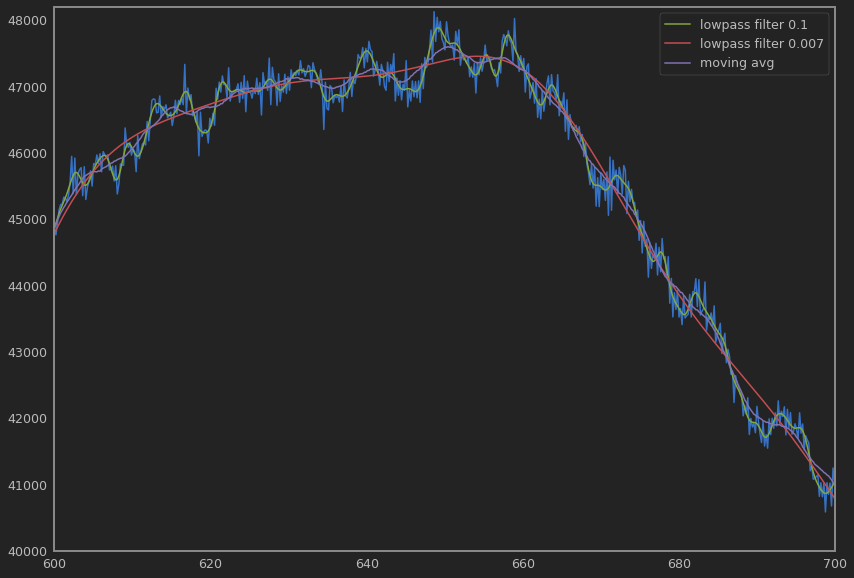

In [348]:
plt.figure(figsize = (14, 10))
plt.plot(ruby.iloc[:,0], ruby.Intensity)
plt.plot(ruby.iloc[:,0], fft_filter(ruby.Intensity, .1), label = 'lowpass filter 0.1')
plt.plot(ruby.iloc[:,0], fft_filter(ruby.Intensity, .007), label = 'lowpass filter 0.007')
plt.plot(ruby.iloc[:,0], moving_avg_filter(ruby.Intensity), label = 'moving avg')
plt.legend()
plt.xlim([600,700])
plt.ylim([40000,48200])
plt.show()

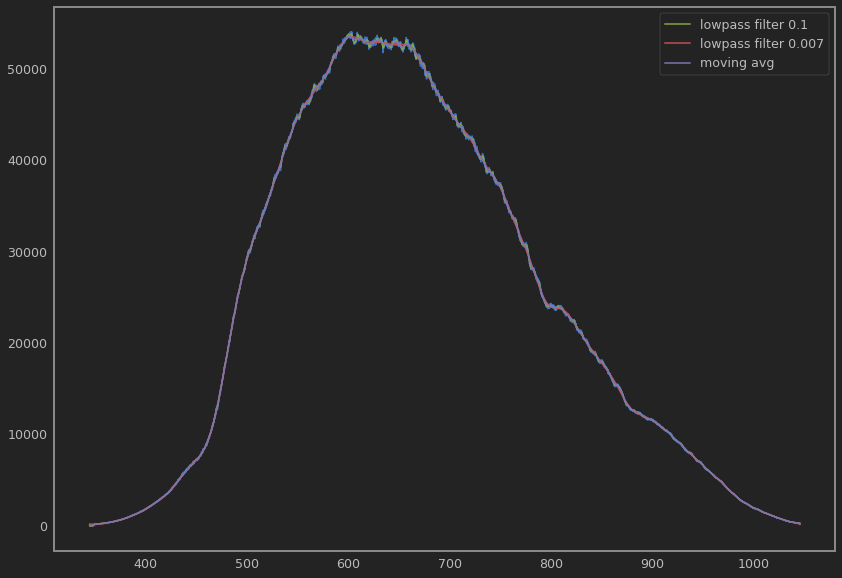

In [369]:
plt.figure(figsize = (14, 10))
plt.plot(no_ruby.iloc[:,0], no_ruby.Intensity)
plt.plot(no_ruby.iloc[:,0], fft_filter(no_ruby.Intensity, .1), label = 'lowpass filter 0.1')
plt.plot(no_ruby.iloc[:,0], fft_filter(no_ruby.Intensity, .007), label = 'lowpass filter 0.007')
plt.plot(no_ruby.iloc[:,0], moving_avg_filter(no_ruby.Intensity), label = 'moving avg')
plt.legend()
# plt.xlim([600,700])
# plt.ylim([40000,58200])
plt.show()

$$ I = I_0(1-R)^2 e^{-\alpha L} $$
$$ \frac{T}{(1-R)^2} = e^{-\alpha L} $$
$$ ln\left(\frac{T}{(1-R)^2}\right) = -\alpha L $$
$$ \alpha = \frac{-1}{L} \cdot ln\left(\frac{T}{(1-R)^2}\right) $$
$$ R = \frac{(n-1)^2}{(n+1)^2} $$

(1.0, 2.0)

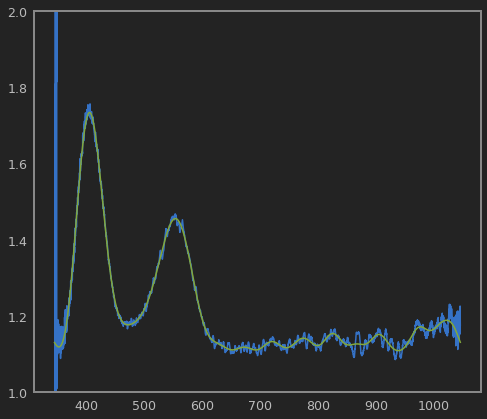

In [371]:
plt.plot(ruby.iloc[:,0], no_ruby.Intensity/ruby.Intensity)
plt.plot(ruby.iloc[:,0], fft_filter(no_ruby.Intensity/ruby.Intensity, .005))
plt.ylim([1, 2])

In [349]:
R

0.06721536351165978

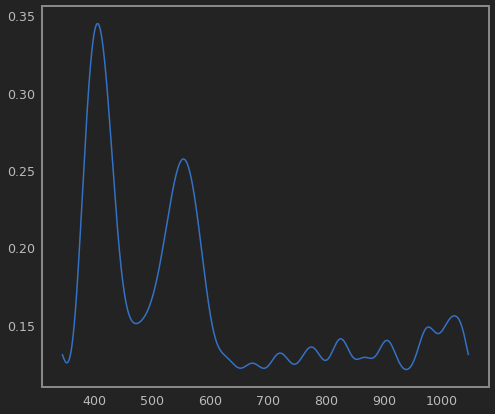

In [397]:
R = (n-1)**2*((n+1)**-2)
transmission = no_ruby.Intensity/ruby.Intensity
transmission = pd.Series(fft_filter(
    transmission, .005))#, index=no_ruby.Wavelength)

absorption = 1/2 * np.log(
    transmission/(
        (1-R)**2)
)
# smooth_abs = fft_filter(absorption.loc[0:], .01)
plt.plot(ruby.Wavelength, absorption)
# plt.ylim([0, absorption.loc[20:].max()*1.05])

In [402]:
1/absorption.loc[absorption==absorption.max()]

280    2.900258
dtype: float64

In [401]:
nu.halfmax(absorption.values, absorption.loc[absorption == absorption.max()].index)[
    0] * (ruby.Wavelength[1] - ruby.Wavelength[0])

array([56.48642515])

### Part D - Ruby Flourescence Spectrum

#### Measurements

In [403]:
col_focal_length = 25 # mm
crystal_distance = 35 # mm
optic_distance = 87.5 # mm

In [406]:
flourescence = pd.read_csv('../Lab3/Data/d.txt', delimiter = '\t', skiprows = 13)

flourescence.columns = ['Intensity']

flourescence.insert(0, 'Wavelength', flourescence.index.tolist())

flourescence.index = range(len(flourescence))

#### Analysis

In [434]:
fig = figure()
fig.line(flourescence.Wavelength, flourescence.Intensity)
fig.line(flourescence.Wavelength, fft_filter(
    flourescence.Intensity, .1), color='red')
flourescence.Intensity = fft_filter(
    flourescence.Intensity, .1)
show(fig)

In [1077]:
wav, peak = nu.peak(flourescence.Intensity, 1, indeces = flourescence.Wavelength)
wav, 1239.84197/wav[0], get_color(wav[0])

([711.6110000000698], 1.7423029857603076, 'Red')

### E - Flourescence Lifetime of Ruby R-line

#### Data

In [913]:
flour = pd.read_csv('../Lab3/Data/RUBY_E_a.csv', header = None)[[3,4,10]]
flour.columns = ['t','square','emission']
flour

,t,square,emission
0,-0.1580,5.12,0.00216
1,-0.1579,5.12,0.00208
2,-0.1578,5.12,0.00224
3,-0.1577,5.12,0.00216
4,-0.1576,5.12,0.00216
...,...,...,...
2495,0.0915,0.24,-0.00056
2496,0.0916,0.24,-0.00056
2497,0.0917,0.24,-0.00048
2498,0.0918,0.24,-0.00040


In [933]:
flour.insert(flour.shape[1], 'observation', None)

In [937]:
flour.loc[(flour.t < -.1) & (flour.square<=.24), 'observation'] = 1
flour.loc[(flour.t > -.1) & (flour.t < .03) & (flour.square<=.24), 'observation'] = 2
flour.loc[(flour.t > .03) & (flour.square<=.24), 'observation'] = 3

In [1073]:
from scipy.optimize import curve_fit



def exp_fit_emission(to_fit):
    if to_fit.t.max() < 0:
        isneg = -1
    else:
        isneg = 1
    def exponential(t, N_0, tau, offset, shift):
        return N_0 * np.exp(
            -(t- isneg * shift)/tau
        ) - offset
    # to_fit.emission -= to_fit.emission.min()*1.0001
    (N_0, tau, offset, shift), covs = curve_fit(
        exponential, to_fit.t, to_fit.emission, maxfev=10000)
    print(N_0)
    fitline = [exponential(t0, N_0, tau, offset, shift) for t0 in to_fit.t]
    return fitline, tau

In [1033]:
newmaybe.observation = newmaybe.observation.replace({None:0})

In [1067]:
dir(fig.xgrid.band_hatch_extra())

['__annotations__',
 '__cached_all__overridden_defaults__',
 '__cached_all__properties__',
 '__cached_all__properties_with_refs__',
 '__class__',
 '__container_props__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__overridden_defaults__',
 '__properties__',
 '__properties_with_refs__',
 '__qualified_model__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__view_model__',
 '__view_module__',
 '__weakref__',
 '_attach_document',
 '_callbacks',
 '_clear_extensions',
 '_clone',
 '_detach_document',
 '_document',
 '_event_callbacks',
 '_id',
 '_initialized',
 '_overridden_defaults',
 '_property_values',
 '_repr_html_',
 '_temp_document',
 '_to_json_like',
 '_trigger_event',
 '_unstable_default_values',
 '_unstable_themed_values',
 '_update_

In [1074]:
fig = figure(width=1400, height=700)
fig.scatter(newmaybe.loc[newmaybe.observation < 1].t,
            newmaybe.loc[newmaybe.observation < 1].emission, color='red', alpha=.3)
colors = {1: 'red', 2: 'red', 3: 'red'}
taus = []
for i, g in newmaybe.groupby('observation'):
    if i == 0:
        continue
    fitline, tau = exp_fit_emission(g)
    fig.line(g.t, fitline, color='black', line_width=4,
             legend_label='Curve Fits', level='overlay')
    fig.scatter(g.t, g.emission,
                color=colors[i], legend_label='Photodiode Response')
    taus.append(tau)
fig.yaxis.axis_label = 'mV'
fig.xaxis.axis_label = 'Time (s)'
ticks = np.linspace(newmaybe.t.min(), newmaybe.t.max(), 6)
fig.xaxis[0].ticker = ticks
fig.xgrid[0].ticker = ticks
fig.square([0], [0], color = 'lightgrey', alpha = .8, legend = 'LASER OFF', visible = False)

fig.xgrid.band_hatch_pattern = "/"
fig.xgrid.band_hatch_alpha = 0.8
fig.xgrid.band_hatch_color = "lightgrey"
fig.xgrid.band_hatch_weight = 0.5
fig.xgrid.band_hatch_scale = 10
show(fig)

0.8549126803225469
0.9504714045556905


/home/trevormjs/anaconda3/envs/conda_env/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.12453497675363458


In [1020]:
taus

[0.003545786163544797, 0.003539310184523837, 0.0034737623471238275]

In [1017]:
cop = flour.loc[flour.observation == 1]
fix = flour.loc[flour.observation == 3]
cop.index = range(cop.shape[0])
fix.index = range(fix.shape[0])
add = cop.loc[~cop.index.isin(fix.index)]
add.t += fix.t[0] - cop.t[0]
add.observation = 3

fig = figure()
fig.line(cop.index, cop.t, legend_label = 'cop', color = 'black')
fig.line(fix.index, fix.t, legend_label = 'fix', color = 'red')
fig.line(add.index, add.t, legend_label = 'add', color = 'green')
show(fig)

newmaybe = pd.concat([flour, add])

/home/trevormjs/anaconda3/envs/conda_env/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [1024]:
newmaybe = newmaybe.loc[~(newmaybe.index <
                          newmaybe.loc[newmaybe.observation == 1].index[0])]

In [1022]:
newmaybe.loc[newmaybe.observation == 1].index[0]

29

In [999]:
taus = pd.Series(taus)
(taus - taus.mean()).std()

4.018993716188295e-05

In [986]:
tau

0.003545786377723208

In [984]:
[exp_fit_emission(
    to_fit=flour.loc[flour.observation == i]) for i in range(1, 4)]

[None, None, None]

In [927]:
flour.square.value_counts()

0.24    1431
5.12    1064
2.96       1
4.16       1
3.44       1
4.56       1
0.32       1
Name: square, dtype: int64

$$ N(t) = N_0 e^{-t/\tau} $$

$$ ln(N(t)) = ln(N_0 e^{-t/\tau}) $$

$$ ln(N(t)) = ln(N_0) + ln(e^{-t/\tau}) $$

$$ ln(N(t)) = ln(N_0) + -t/\tau $$

$$ ln(N(t)) = mx + b $$

$$ m = -1/\tau,\ \ \ \ b = ln(N_0) $$

### Data Classes

In [499]:
from dataclasses import dataclass, asdict, field, fields

In [818]:
print(Unit('k','Wh') == Unit('M','Wh'))

True


In [819]:
SI_unit_dict = {
    -2: 'c',
    -3: 'm',
    -6: '\u03BC',
    -9: 'n',
    0: ' ',
    3: 'k',
    6: 'M',
    9: 'G',
    12: 'T'
}

inv_SI_unit_dict = {k: i
                    for i, k in SI_unit_dict.items()}

In [820]:
inv_SI_unit_dict

{'c': -2, 'm': -3, 'μ': -6, 'n': -9, ' ': 0, 'k': 3, 'M': 6, 'G': 9, 'T': 12}

In [885]:
test = 'A^-3h^2*m*m'
units = set([un for un in test if 
                    not any(un==char for char in '*^-') and not un.isdigit()])
units

{'A', 'h', 'm'}

In [889]:
from uncertainties import ufloat
from Helper.numbers import print_unc


@dataclass(eq=False)
class Unit:
    scale: str = field()
    unit: str = field()

    def __post_init__(self):
        self.e = inv_SI_unit_dict[self.scale]

    def __repr__(self):
        return self.scale + self.unit

    def __eq__(self, other):
        if self.unit == other.unit:
            return True

    def __mul__(self, other):
        newscale = SI_unit_dict[self.e + other.e]
        newunit = self.unit.split('*') + other.unit.split('*')

        return Unit(newscale, '*'.join(newunit)


@dataclass(eq=False)
class Measurement:
    value: float = field()
    unc: float = field()
    unit: Unit = field()

    def __post_init__(self):
        self.ufloat = self.__ufloat__()
        self.interval = self.__interval__()

    def __ufloat__(self):
        return ufloat(
            self.value, self.unc) *\
            10**inv_SI_unit_dict[self.unit.scale]

    def __interval__(self):
        return [self.ufloat.n-self.ufloat.s,
                self.ufloat.n+self.ufloat.s]

    def __str__(self):
        val, unc, digs = print_unc(self.value, self.unc, False)
        return f'{val} +/- {unc} {self.unit}'

    def __eq__(self, other):
        if self.unit != other.unit:
            return False
        if self.interval[0] < other.interval[1] < self.interval[1]:
            return True
        if self.interval[0] < other.interval[0] < self.interval[1]:
            return True
        return False

    def __mul__(self, other):
        return Measurement(self.value * other.value,
                           (self.unc**2 + other.unc**2)**.5,
                           self.unit*other.unit)

In [890]:
intensity1 = Measurement(0.42, .01, mku('mAh'))

In [893]:
mW = Unit(*'mW')
def mku(s): return Unit(**{'scale': s[0], 'unit': s[1:]})


intensity1 = Measurement(0.42, .01, mku('mA*h'))
intensity2 = Measurement(0.47, .05, mku('MA*h'))
# constant = Measurement(100, 0.0, mku(' A^-2*h^-1'))

print(asdict(intensity1))

print(asdict(intensity2))

print(intensity2 == intensity1)

prod = intensity2 * intensity1# * constant
display(prod)
print(prod)

{'value': 0.42, 'unc': 0.01, 'unit': {'scale': 'm', 'unit': 'A*h'}}
{'value': 0.47, 'unc': 0.05, 'unit': {'scale': 'M', 'unit': 'A*h'}}
False


Measurement(value=0.1974, unc=0.050990195135927854, unit=kA*h*A*h)

0.2 +/- 0.05 kA*h*A*h
